# 1. Environment Setup

In [19]:
%pip install tensorflow numpy xarray scikit-learn keras matplotlib pandas pillow tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D, Activation, Add, Multiply, Lambda, UpSampling2D, BatchNormalization,
    Concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape
)
from tensorflow.keras.backend import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Visualization
import matplotlib.pyplot as plt

# File handling and utilities
import os
import pickle
from tqdm import tqdm
from PIL import Image, ImageOps
import urllib.request

# Other
import datetime


## 1.2 Process Data

In [21]:
# Download GridMet tmin (1/24 deg, ~4km)
gridmet_url = 'https://www.northwestknowledge.net/metdata/data/tmmn_2021.nc'
gridmet_savename = 'tmin_gridmet_2021.nc'
urllib.request.urlretrieve(gridmet_url, gridmet_savename)

# Download CPC-Globe tmin (0.5 deg, ~50km)
cpc_url = 'https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmin.2021.nc'
cpc_savename = 'tmin_CPC_2021.nc'
urllib.request.urlretrieve(cpc_url, cpc_savename)

# Load datasets
gridmet = xr.open_dataset('tmin_gridmet_2021.nc')
cpc = xr.open_dataset('tmin_CPC_2021.nc')

# Extract common dates between CPC and GridMet
common_dates = np.intersect1d(cpc['time'].values, gridmet['day'].values)
with open('common_dates.pkl', 'wb') as f:
    pickle.dump(common_dates, f)

In [22]:
# Format Gridmet data to match CPC
cpc = cpc.rename({'time':'day'})
gridmet = gridmet.drop('crs').rename({'air_temperature':'tmin'})
gridmet = gridmet-273.15 # Convert Kelvin to Celcius
lon_revised = gridmet.lon + (gridmet.lon < 0)*360
gridmet = gridmet.assign_coords(lon = lon_revised)

## 1.2 Create and Format Plots

In [24]:
# Directories to save CPC and GridMet plots separately
cpc_output_dir = 'cpc_plots'
gridmet_output_dir = 'gridmet_plots'
os.makedirs(cpc_output_dir, exist_ok=True)
os.makedirs(gridmet_output_dir, exist_ok=True)

# Function to plot and save CPC and GridMet images separately
def create_and_save_plots(cpc, gridmet, common_dates, cpc_output_dir, gridmet_output_dir):
    for date in tqdm(common_dates, desc="Saving plots", unit="date"):
        try:
            # Plot and save the CPC (low-res) data
            plt = plot_maps(cpc, date)
            plt.savefig(os.path.join(cpc_output_dir, f'cpc_{str(date)[:10]}.png'))
            plt.close()

            # Plot and save the GridMet (high-res) data
            plt = plot_maps(gridmet, date)
            plt.savefig(os.path.join(gridmet_output_dir, f'gridmet_{str(date)[:10]}.png'))
            plt.close()

        except KeyError:
            print(f"Skipping date {str(date)[:10]}")

# Call the function to plot and save images separately
create_and_save_plots(cpc, gridmet, common_dates, cpc_output_dir, gridmet_output_dir)

print(f"CPC plots saved in the directory: {cpc_output_dir}")
print(f"GridMet plots saved in the directory: {gridmet_output_dir}")


Saving plots: 100%|██████████| 365/365 [02:44<00:00,  2.22date/s]

CPC plots saved in the directory: cpc_plots
GridMet plots saved in the directory: gridmet_plots


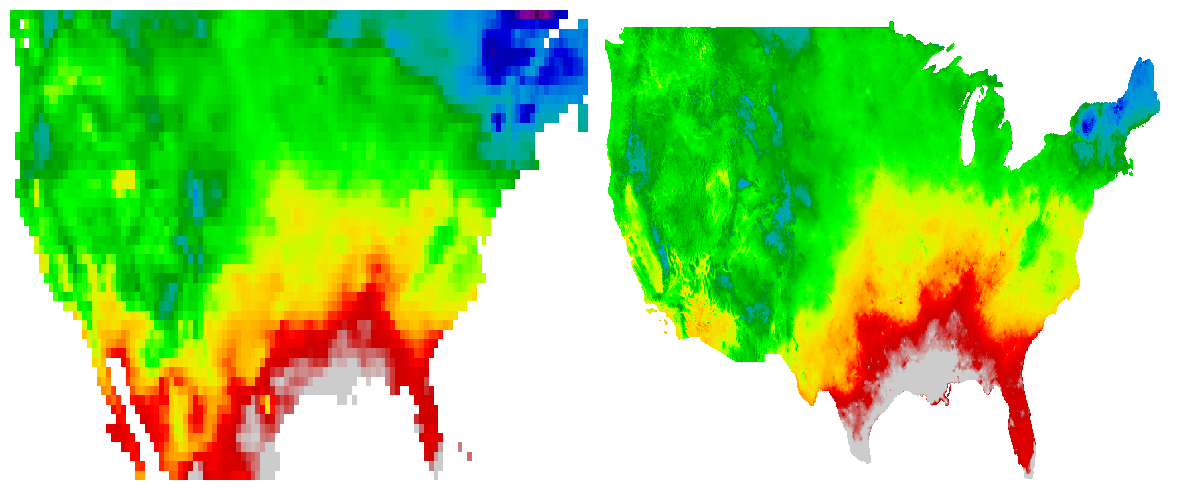

In [ ]:
# Define the target date and convert it to pandas datetime
target_date = datetime.date(2021, 3, 16)
target_date = pd.to_datetime(target_date)

# Define the x and y limits for the plots
xlim = [235, 295]
ylim = [25, 50]

# Function to plot a single map
def plot_map(ax, data, date, xlim, ylim):
    data_day = data.sel(day=date)
    data_day.tmin.plot(
        ax=ax,
        cmap='nipy_spectral',
        vmin=-30,
        vmax=20,
        add_colorbar=False
    )  # Remove colorbar
    ax.set_xlim(xlim)  # Set x-axis limits
    ax.set_ylim(ylim)  # Set y-axis limits
    ax.axis('off')  # Hide axes
    ax.set_title("")  # Remove title
    
# Create the figure and axes for side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='w')  # Create a figure with 2 subplots

# Plot the maps on each subplot
plot_map(axes[0], cpc, target_date, xlim, ylim)  # Replace `cpc` with your data object
plot_map(axes[1], gridmet, target_date, xlim, ylim)  # Replace `gridmet` with your data object

# Adjust layout
plt.tight_layout()
plt.show()

## 1.4 Apply Mask

In [27]:
# Load common_dates from the file
with open('common_dates.pkl', 'rb') as f:
    common_dates = pickle.load(f)

# Directories
cpc_output_dir = 'cpc_plots'
gridmet_output_dir = 'gridmet_plots'
masked_cpc_output_dir = 'masked_cpc_plots'

# Ensure the output directory exists
if not os.path.exists(masked_cpc_output_dir):
    os.makedirs(masked_cpc_output_dir)


In [28]:
def resize_with_padding(image, target_size):
    """
    Resize image to the target size while maintaining aspect ratio and adding white padding.
    :param image: PIL Image
    :param target_size: Tuple (width, height) for resizing
    :return: Resized and padded PIL Image
    """
    original_width, original_height = image.size
    target_width, target_height = target_size

    # Calculate the new size to maintain aspect ratio
    aspect_ratio = original_width / original_height
    if aspect_ratio > 1:  # Wide image
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:  # Tall image
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.BICUBIC)

    # Create a new image with the target size and paste the resized image centered
    new_image = Image.new("RGB", target_size, (255, 255, 255))  # White background
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image

def mask_and_save_images(dates, cpc_dir, gridmet_dir, masked_cpc_dir, prefix_cpc, prefix_gridmet, target_size):
    """
    For each date, load CPC and GridMet images, apply the mask, and save the masked CPC image.
    """
    for date in tqdm(dates, desc="Processing and masking images"):
        cpc_img_path = os.path.join(cpc_dir, f'{prefix_cpc}_{str(date)[:10]}.png')
        gridmet_img_path = os.path.join(gridmet_dir, f'{prefix_gridmet}_{str(date)[:10]}.png')
        masked_cpc_img_path = os.path.join(masked_cpc_dir, f'{prefix_cpc}_{str(date)[:10]}.png')
        try:
            # Load images
            cpc_img = Image.open(cpc_img_path).convert('RGB')
            gridmet_img = Image.open(gridmet_img_path).convert('RGB')

            # Resize images with padding
            cpc_img = resize_with_padding(cpc_img, target_size)
            gridmet_img = resize_with_padding(gridmet_img, target_size)

            # Convert images to numpy arrays
            cpc_array = np.array(cpc_img)
            gridmet_array = np.array(gridmet_img)

            # Create a mask where the GridMet image is white
            white_pixel = [255, 255, 255]
            mask = np.all(gridmet_array == white_pixel, axis=-1)

            # Apply the mask to the CPC image
            cpc_array[mask] = white_pixel

            # Convert the masked array back to an image
            masked_cpc_img = Image.fromarray(cpc_array.astype('uint8'))

            # Save the masked CPC image
            masked_cpc_img.save(masked_cpc_img_path)

        except FileNotFoundError:
            print(f"File not found for date {date}: {cpc_img_path} or {gridmet_img_path}")

# Define target size for resizing
target_size = (224, 224)  # Adjust as needed

mask_and_save_images(common_dates, cpc_output_dir, gridmet_output_dir, masked_cpc_output_dir, 'cpc', 'gridmet', target_size)

Processing and masking images: 100%|██████████| 365/365 [00:06<00:00, 56.45it/s]


## 1.5 Train / Test Split Data

In [29]:
# Dates for train/test splits
"""
common_dates = np.intersect1d(cpc['day'].values, gridmet['day'].values)
common_dates = list(common_dates)"""
np.random.seed(42)
test_dates = np.random.choice(common_dates, size=30, replace=False)

# Dataset creation
test_dates = list(test_dates)
training_dates = list(set(common_dates) - set(test_dates))
test_dates = pd.to_datetime(test_dates)
training_dates = pd.to_datetime(training_dates)

print("Test Dates:", test_dates)

Test Dates: DatetimeIndex(['2021-07-13', '2021-02-03', '2021-01-16', '2021-11-06',
               '2021-02-27', '2021-07-03', '2021-03-18', '2021-04-30',
               '2021-06-02', '2021-05-07', '2021-12-05', '2021-02-09',
               '2021-11-01', '2021-02-25', '2021-05-18', '2021-10-28',
               '2021-01-01', '2021-10-03', '2021-11-26', '2021-04-12',
               '2021-01-10', '2021-06-15', '2021-03-14', '2021-09-11',
               '2021-09-06', '2021-07-15', '2021-08-09', '2021-10-20',
               '2021-12-16', '2021-12-28'],
              dtype='datetime64[ns]', freq=None)


In [30]:
def load_images(dates, output_dir, prefix, target_size):
    """
    Load images from the specified directory and resize with padding.
    :param dates: List of dates corresponding to the image filenames
    :param output_dir: Directory containing the images
    :param prefix: Filename prefix for the images
    :param target_size: Tuple (width, height) for resizing
    :return: Numpy array of images
    """
    images = []
    for date in tqdm(dates, desc=f"Loading images from {output_dir}"):
        img_path = os.path.join(output_dir, f'{prefix}_{str(date)[:10]}.png')
        try:
            img = Image.open(img_path).convert('RGB')  # Convert to RGB if needed
            img = resize_with_padding(img, target_size)  # Resize with padding
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
    return np.array(images)

# Define target size for resizing
target_size = (224, 224)  # Choose (224, 224) or another size if needed

# Load CPC and GridMet images as numpy arrays for train and test sets
X_train = load_images(training_dates, masked_cpc_output_dir, 'cpc', target_size)
X_test = load_images(test_dates, masked_cpc_output_dir, 'cpc', target_size)
y_train = load_images(training_dates, gridmet_output_dir, 'gridmet', target_size)
y_test = load_images(test_dates, gridmet_output_dir, 'gridmet', target_size)

# Display the shapes of the datasets
print("Training X shape:", X_train.shape)
print("Training Y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test Y shape:", y_test.shape)


Loading images from gridmet_plots: 100%|██████████| 30/30 [00:00<00:00, 135.50it/s]

Training X shape: (335, 224, 224, 3)
Training Y shape: (335, 224, 224, 3)
Test X shape: (30, 224, 224, 3)
Test Y shape: (30, 224, 224, 3)


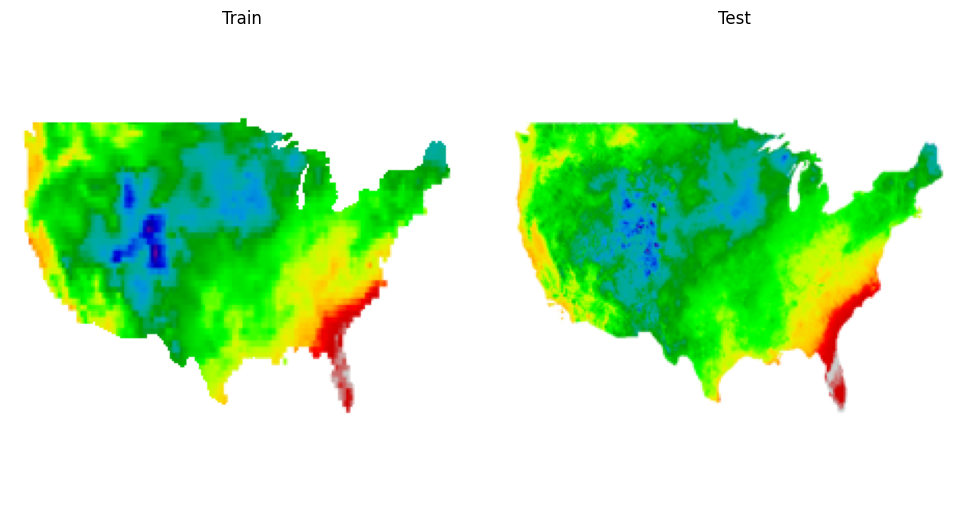

In [31]:
import matplotlib.pyplot as plt

# Function to display two images side by side
def display_images(image1, image2, title1, title2):
    plt.figure(figsize=(10, 5))

    # Display the first image (X[0])
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title(title1)
    plt.axis('off')

    # Display the second image (Y[0])
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display the first image from X_train and y_train
display_images(X_train[0], y_train[0], title1="Train", title2="Test")

# 2. Base Autoencoder

In [22]:
# Define the input shape based on your CPC images (adjust the shape if needed)
input_shape = Input(shape=(224, 224, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_shape)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu')(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu')(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu')(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu')(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu')(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu')(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(l15)

autoencoder = Model(input_shape, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_36[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 112, 112,  │          0 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 112, 112,  │     73,856 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_38[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_11    │ (None, 112, 112,  │          0 │ conv2d_40[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │    295,040 │ up_sampling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_41[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 112, 112,  │          0 │ conv2d_39[0][0],  │
│                     │ 128)              │            │ conv2d_42[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 224, 224,  │          0 │ add_6[0][0]       │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 224, 224,  │     73,792 │ up_sampling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_43[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 224, 224,  │          0 │ conv2d_44[0][0],

 Total params: 1,110,403 (4.24 MB)

 Trainable params: 1,110,403 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
batch_size = 16
epochs = 50

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the autoencoder model with EarlyStopping
history = autoencoder.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split = 0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - loss: 0.1202 - val_loss: 0.0248
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - loss: 0.0204 - val_loss: 0.0139
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0139 - val_loss: 0.0115
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0120 - val_loss: 0.0125
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0124 - val_loss: 0.0105
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0105 - val_loss: 0.0112
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0128 - val_loss: 0.0118
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0119 - val_loss: 0.0110
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0108 - val_loss: 0.0104
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - loss: 0.0106 - val_loss: 0.0100
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0103 - val_loss: 0.0099
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - loss: 0.0095 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


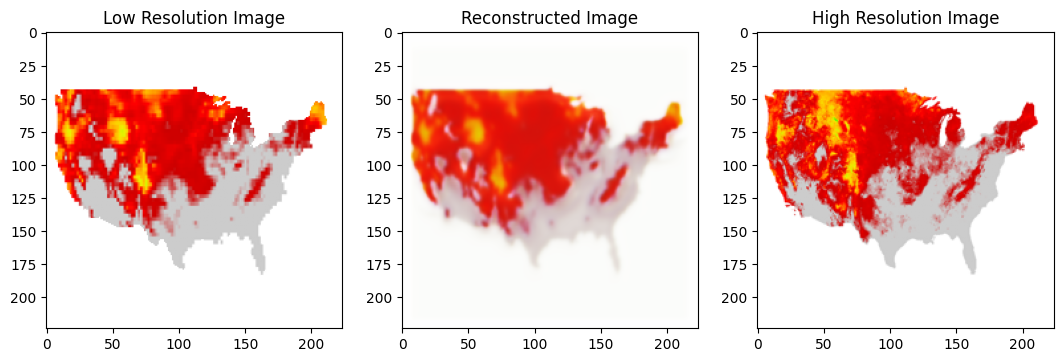

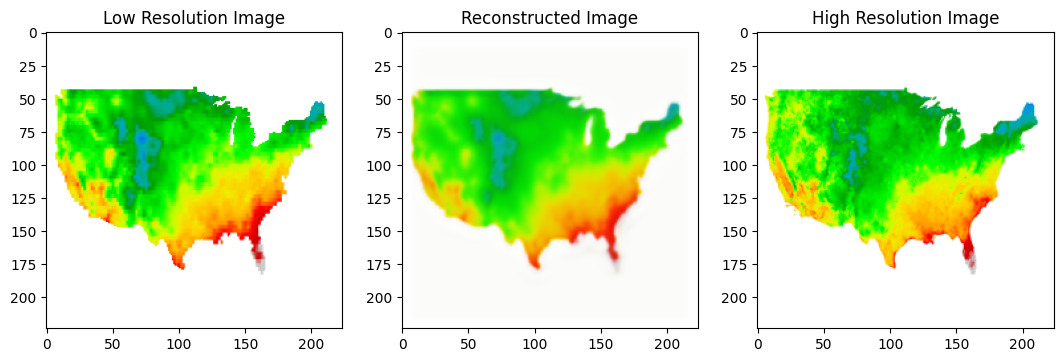

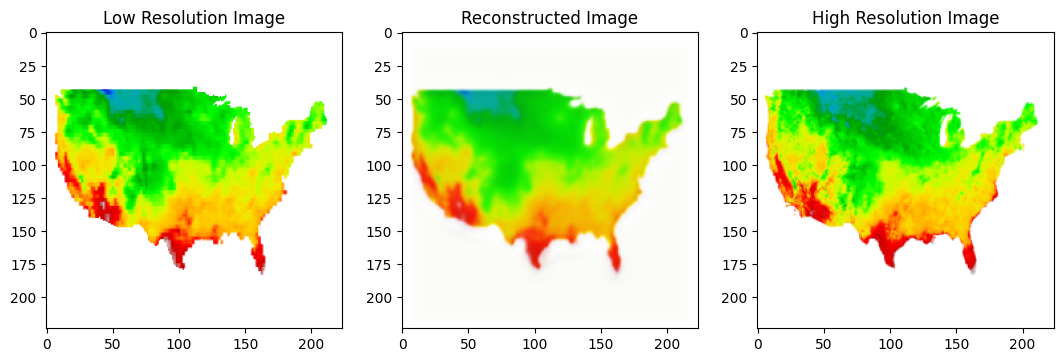

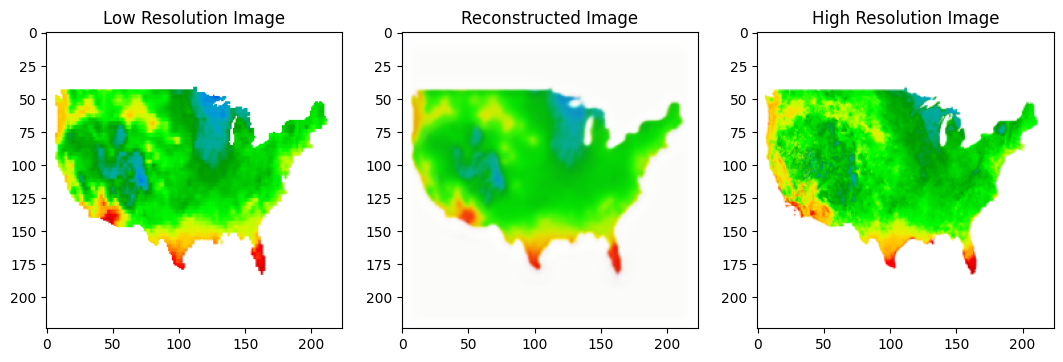

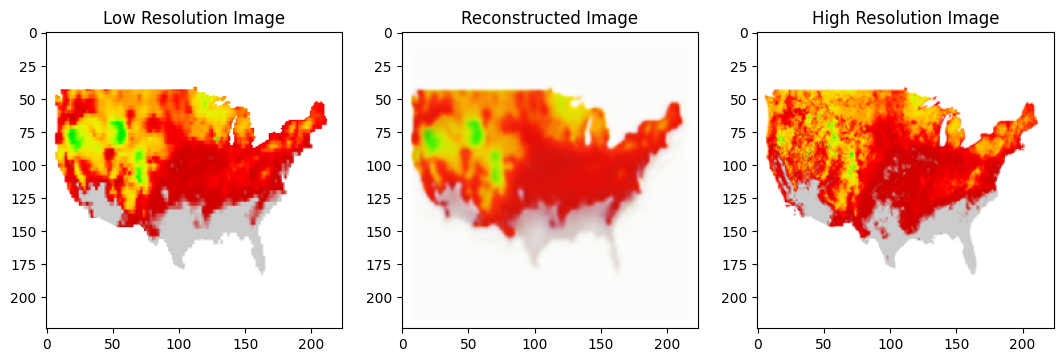

In [24]:
decoded_imgs = autoencoder.predict(X_test)

for i in range(0,5):
    fig, axs = plt.subplots(1 , 3, figsize=(13, 4.5), facecolor='w')
    axs[0].imshow(X_test[i * 6])
    axs[0].set_title('Low Resolution Image')
    axs[1].imshow(decoded_imgs[i * 6])
    axs[1].set_title('Reconstructed Image')
    axs[2].imshow(y_test[i * 6])
    axs[2].set_title('High Resolution Image')
    plt.show()

# 3. Transfer Learning

In [25]:
def autoencoder_transfer_learning(input_shape):
    # Load the ResNet152 model without the top classification layers
    resnet = ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet.trainable = False  # Freeze ResNet152 layers

    # Choose an intermediate layer's output as the encoder output
    # For ResNet152, 'conv5_block3_out' is a good choice (output shape: 7x7x2048 for input 224x224)
    encoder_output = resnet.get_layer('conv5_block3_out').output

    # Decoder to upscale back to high resolution
    x = UpSampling2D((2, 2))(encoder_output)  
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x) 
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x) 
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)  
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)  
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Use 'sigmoid' if pixel values are normalized between 0 and 1

    # Create the autoencoder model
    autoencoder = Model(inputs=resnet.input, outputs=decoder_output)

    # Compile the model
    autoencoder.compile(optimizer=Adam(), loss='mse')

    return autoencoder

In [26]:
# Train the model
batch_size = 16
autoencoder_2 = autoencoder_transfer_learning((224, 224, 3))

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the autoencoder model with EarlyStopping
history = autoencoder_2.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split = 0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - loss: 0.1752 - val_loss: 0.1604
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.1631 - val_loss: 0.1604
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.1626 - val_loss: 0.1604
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - loss: 0.1623 - val_loss: 0.1604
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - loss: 0.1607 - val_loss: 0.1604
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.1645 - val_loss: 0.1604
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.1627 - val_loss: 0.1604
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - loss: 0.1655 - val_loss: 0.1604
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - loss: 0.1617 - val_loss: 0.1604
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - loss: 0.1604 - val_loss: 0.1604
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.1609 - val_loss: 0.1604


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


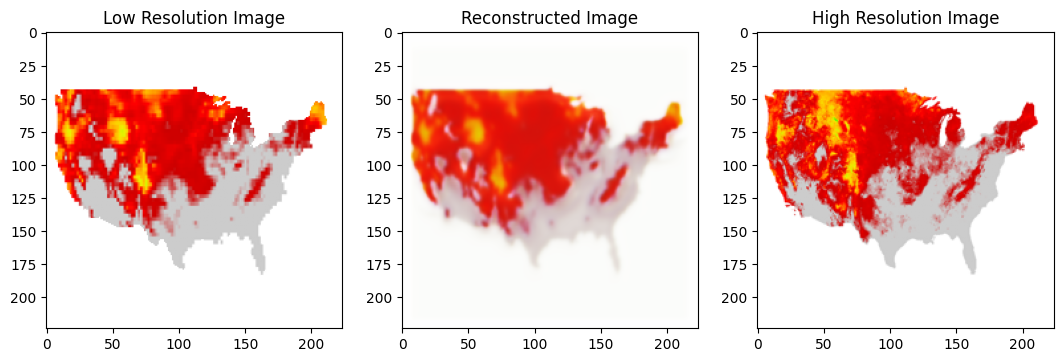

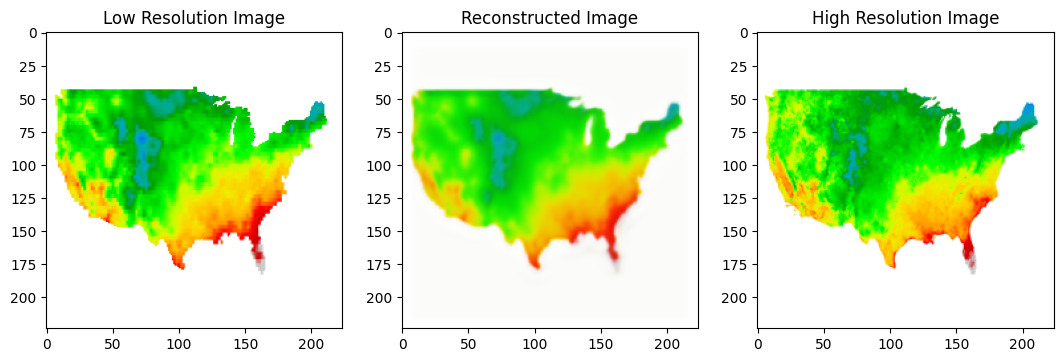

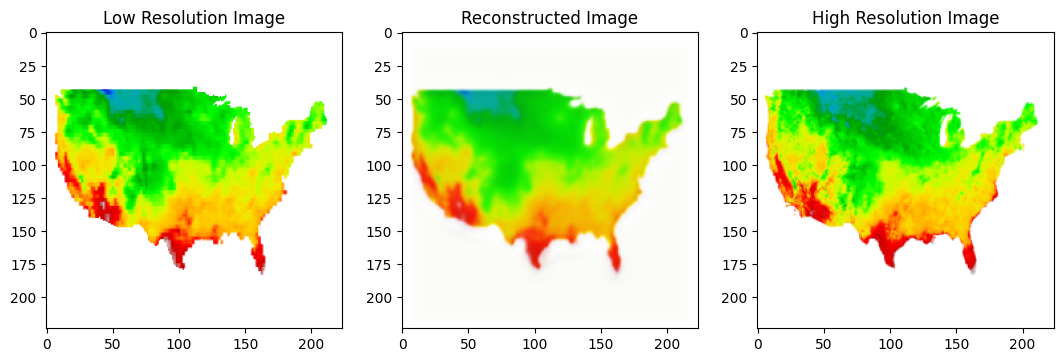

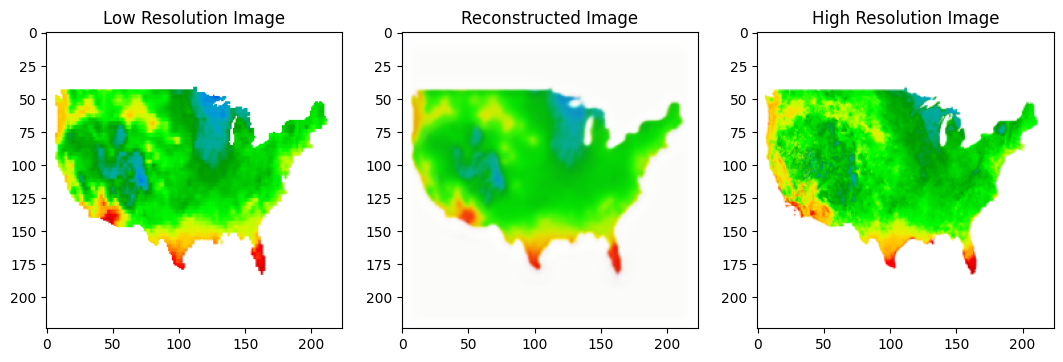

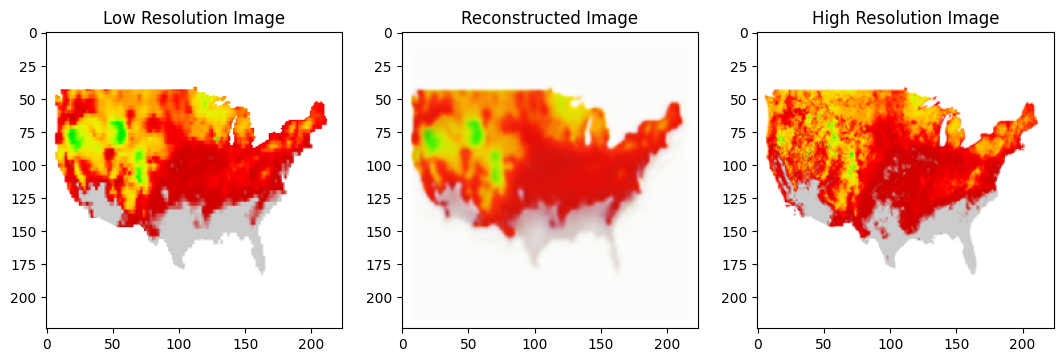

In [27]:
decoded_imgs = autoencoder.predict(X_test)

for i in range(0,5):
    fig, axs = plt.subplots(1 , 3, figsize=(13, 4.5), facecolor='w')
    axs[0].imshow(X_test[i * 6])
    axs[0].set_title('Low Resolution Image')
    axs[1].imshow(decoded_imgs[i * 6])
    axs[1].set_title('Reconstructed Image')
    axs[2].imshow(y_test[i * 6])
    axs[2].set_title('High Resolution Image')
    plt.show()

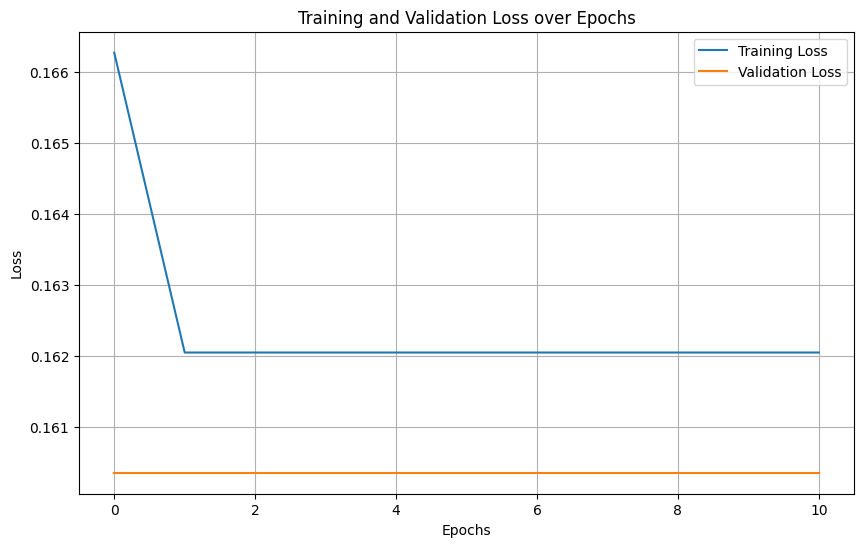

In [28]:
# Plot training and validation loss over epochs
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot loss
plot_loss(history)


# 4. Advanced Network Blocks
- Multi-scale feature fusion
- Residual-in-Residual Dense Blocks (RRDB)
- and Dual Attention Modules (DAM)

In [6]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import (
    UpSampling2D, Conv2D, Add, Multiply, Concatenate, Activation, Dense, 
    Reshape, Lambda, GlobalAveragePooling2D, GlobalMaxPooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf

def autoencoder_complex(input_shape):
    # Load ResNet152 without top layers
    resnet = ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet.trainable = False  # Freeze ResNet152 layers

    # Extract multi-scale features from ResNet152
    x1 = resnet.get_layer('conv2_block3_out').output  # 56x56x256
    x2 = resnet.get_layer('conv3_block8_out').output  # 28x28x512
    x3 = resnet.get_layer('conv4_block36_out').output  # 14x14x1024
    x4 = resnet.get_layer('conv5_block3_out').output  # 7x7x2048

    # Upsample to match spatial dimensions
    x2_up = UpSampling2D(size=(2, 2))(x2)   # 28x28x512 → 56x56x512
    x3_up = UpSampling2D(size=(4, 4))(x3)   # 14x14x1024 → 56x56x1024
    x4_up = UpSampling2D(size=(8, 8))(x4)   # 7x7x2048 → 56x56x2048

    # Concatenate multi-scale features
    x = Concatenate()([x1, x2_up, x3_up, x4_up])  # 56x56x(256+512+1024+2048)=56x56x3840

    # Feature fusion
    x = Conv2D(1024, (1, 1), activation='relu', padding='same')(x)

    # Define Residual Dense Block
    def residual_dense_block(x, filters, growth_rate, num_layers):
        inputs = x
        for _ in range(num_layers):
            x = Conv2D(growth_rate, (3, 3), padding='same')(x)
            x = Activation('relu')(x)
            inputs = Concatenate()([inputs, x])
            x = inputs
        x = Conv2D(filters, (1, 1), padding='same')(x)
        return x

    # Define RRDB block
    def rrdb_block(x, filters, growth_rate, num_layers):
        res = x
        for _ in range(3):
            x = residual_dense_block(x, filters, growth_rate, num_layers)
        # Use Lambda layer for element-wise scaling
        x = Lambda(lambda tensor: tensor * 0.2)(x)  # Scale the tensor by 0.2
        x = Add()([res, x])
        return x

    # Define Dual Attention Module
    def dual_attention_module(x, filters):
        # Channel Attention
        avg_pool = GlobalAveragePooling2D()(x)
        max_pool = GlobalMaxPooling2D()(x)
        dense_avg = Dense(filters // 8, activation='relu')(avg_pool)
        dense_avg = Dense(filters, activation='sigmoid')(dense_avg)
        dense_max = Dense(filters // 8, activation='relu')(max_pool)
        dense_max = Dense(filters, activation='sigmoid')(dense_max)
        channel_att = Add()([dense_avg, dense_max])
        channel_att = Reshape((1, 1, filters))(channel_att)
        x = Multiply()([x, channel_att])

        # Spatial Attention
        avg_spatial = Lambda(lambda tensor: K.mean(tensor, axis=3, keepdims=True))(x)
        max_spatial = Lambda(lambda tensor: K.max(tensor, axis=3, keepdims=True))(x)
        spatial_att = Concatenate(axis=3)([avg_spatial, max_spatial])
        spatial_att = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(spatial_att)
        x = Multiply()([x, spatial_att])

        return x

    # Add multiple RRDB blocks with Dual Attention Modules
    for _ in range(5):  # Start with fewer blocks for stability
        x = rrdb_block(x, filters=1024, growth_rate=64, num_layers=5)
        x = dual_attention_module(x, filters=1024)

    # Upsampling layers using sub-pixel convolution
    def upsample(x, scale, filters):
        x = Conv2D(filters * (scale ** 2), (3, 3), padding='same')(x)
        x = Lambda(lambda z: tf.nn.depth_to_space(z, scale))(x)
        x = Activation('relu')(x)
        return x

    # Adjusted upsampling to reach 224x224
    x = upsample(x, 2, 512)  # 56x56 → 112x112
    x = upsample(x, 2, 256)  # 112x112 → 224x224

    # Final output layer
    decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # 224x224x3

    # Build the model
    autoencoder = Model(inputs=resnet.input, outputs=decoder_output)
    autoencoder.compile(optimizer=Adam(), loss='mse')

    return autoencoder


In [8]:
# Train the model
autoencoder_3= autoencoder_complex((224, 224, 3))

# Train the autoencoder model with EarlyStopping
history = autoencoder_3.fit(
    X_train, y_train,
    epochs=3,
    batch_size=16,
    validation_split = 0.2
)

Epoch 1/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 2027s 118s/step - loss: 0.1651 - val_loss: 0.1444
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 1968s 116s/step - loss: 0.1898 - val_loss: 0.2851
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 1963s 116s/step - loss: 0.2831 - val_loss: 0.2708


1/1 ━━━━━━━━━━━━━━━━━━━━ 62s 62s/step


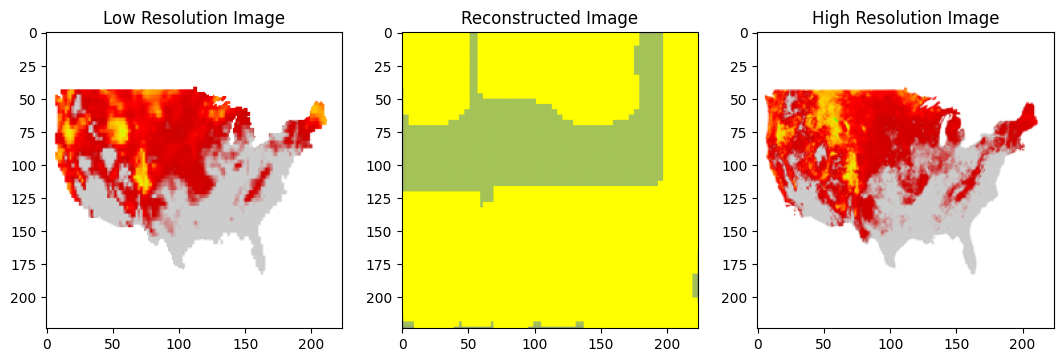

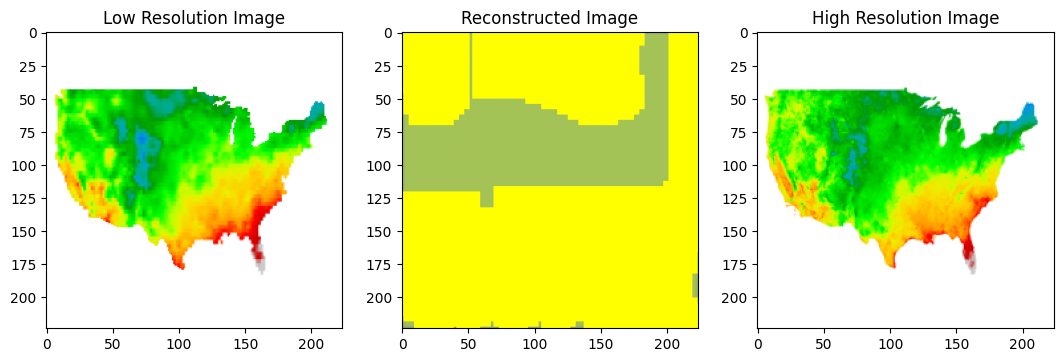

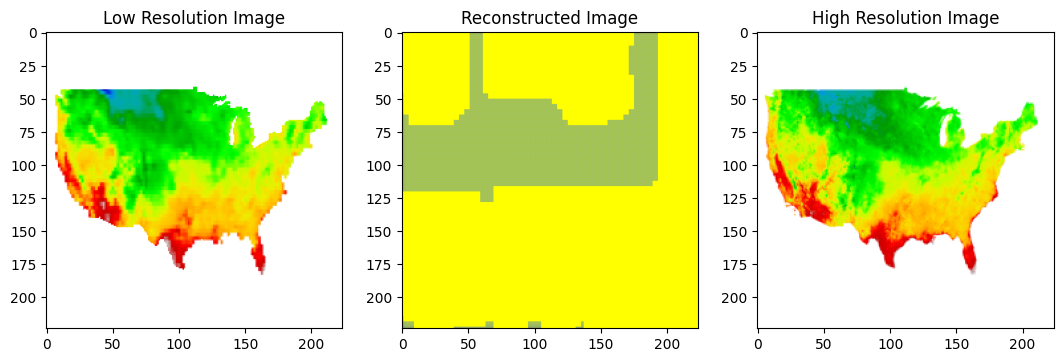

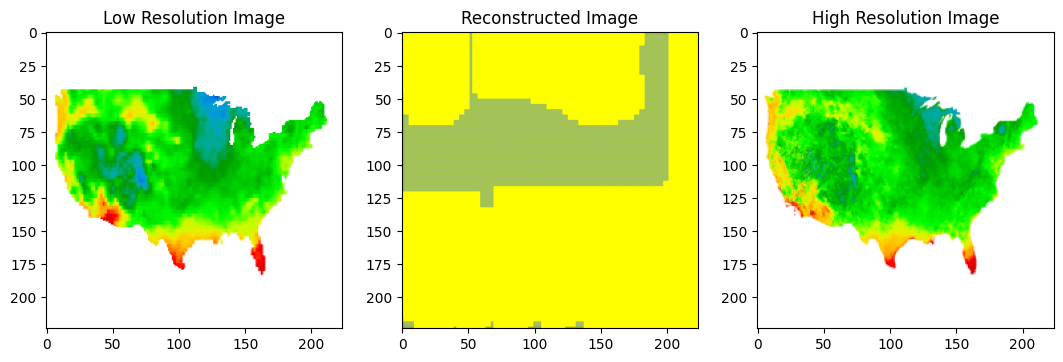

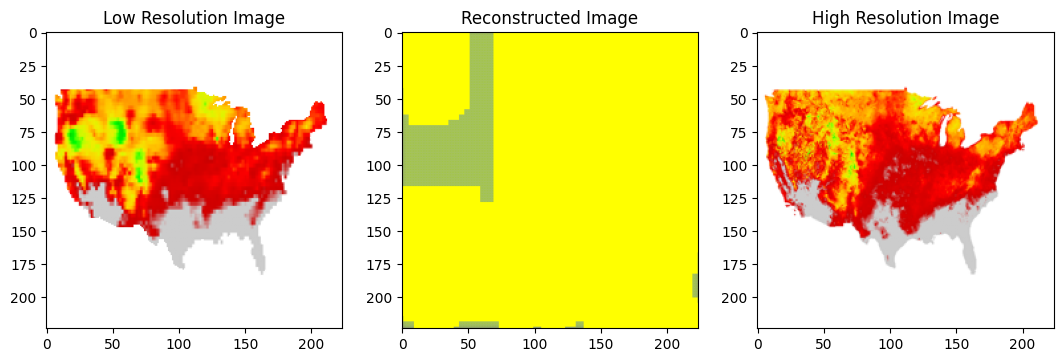

In [9]:
decoded_imgs = autoencoder_3.predict(X_test)

for i in range(0,5):
    fig, axs = plt.subplots(1 , 3, figsize=(13, 4.5), facecolor='w')
    axs[0].imshow(X_test[i * 6])
    axs[0].set_title('Low Resolution Image')
    axs[1].imshow(decoded_imgs[i * 6])
    axs[1].set_title('Reconstructed Image')
    axs[2].imshow(y_test[i * 6])
    axs[2].set_title('High Resolution Image')
    plt.show()

# 6. SSIM Loss Metric

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, add
from tensorflow.keras.models import Model

# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Function to create the autoencoder model
def ssim_autoencoder(input_shape=(224, 224, 3), dropout_rate=0.3):
    # Define the input
    inputs = Input(shape=input_shape)

    # Encoder
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu')(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(dropout_rate)(l3)
    l4 = Conv2D(128, (3, 3), padding='same', activation='relu')(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu')(l4)
    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu')(l6)

    # Decoder
    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu')(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu')(l9)
    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu')(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu')(l13)
    l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(l15)

    # Define the model
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss="mae")

    return autoencoder

In [38]:
ssim_autoencoder = ssim_autoencoder()

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the ssim_autoencoder model with EarlyStopping
history = ssim_autoencoder.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split = 0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - loss: 0.2690 - val_loss: 0.1888
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - loss: 0.1894 - val_loss: 0.1888
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - loss: 0.1910 - val_loss: 0.1888
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - loss: 0.1889 - val_loss: 0.1888
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - loss: 0.1921 - val_loss: 0.1888
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - loss: 0.1924 - val_loss: 0.1888


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


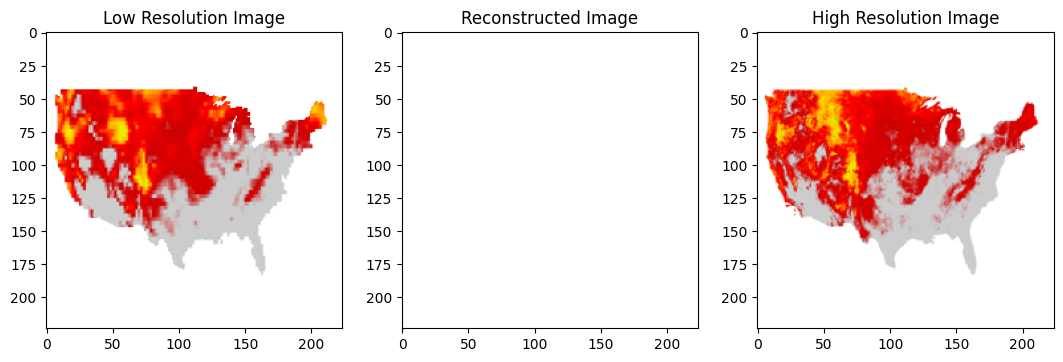

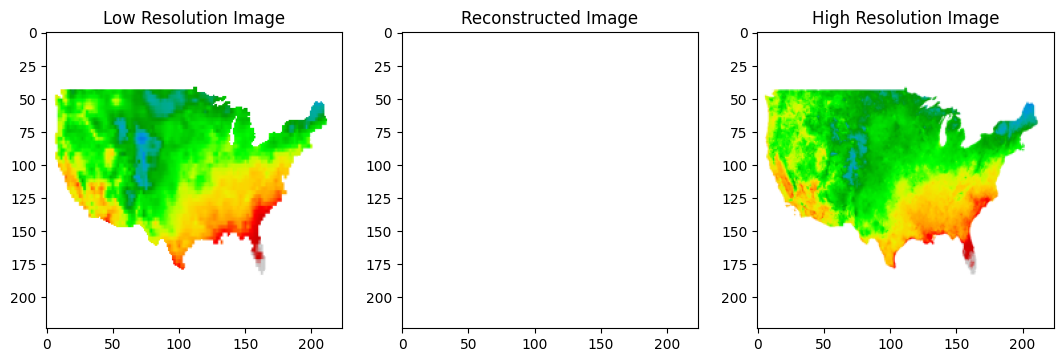

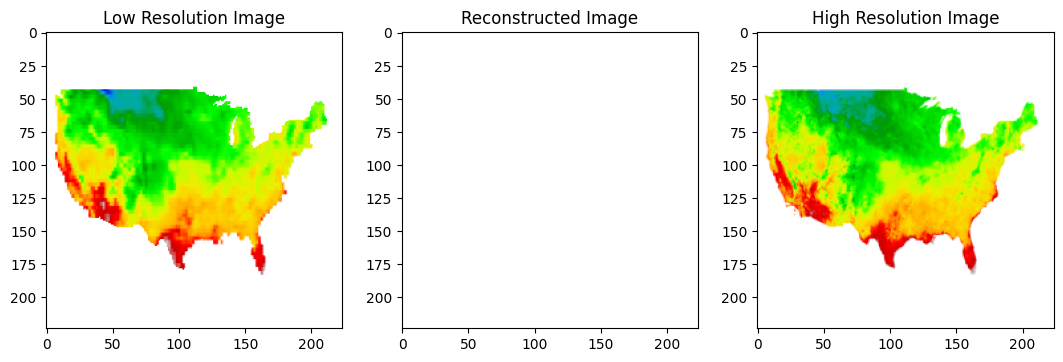

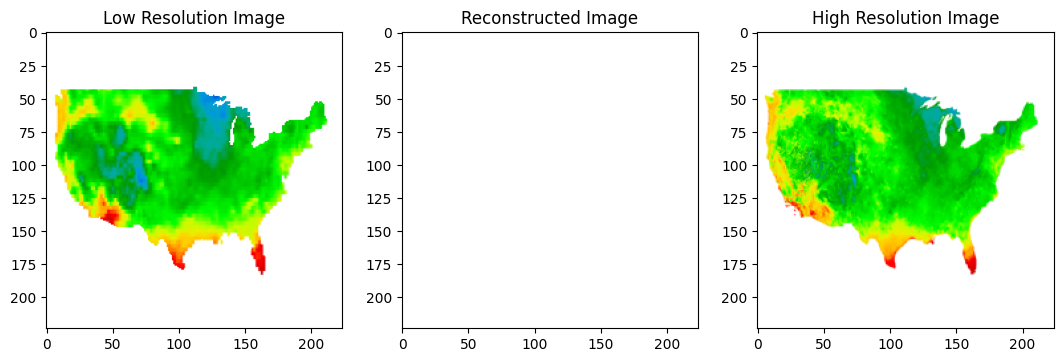

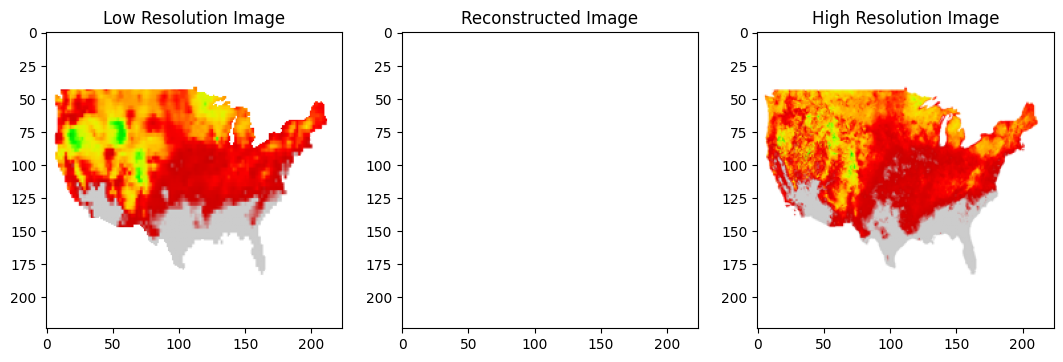

In [35]:
decoded_imgs = ssim_autoencoder.predict(X_test)

for i in range(0,5):
    fig, axs = plt.subplots(1 , 3, figsize=(13, 4.5), facecolor='w')
    axs[0].imshow(X_test[i * 6])
    axs[0].set_title('Low Resolution Image')
    axs[1].imshow(decoded_imgs[i * 6])
    axs[1].set_title('Reconstructed Image')
    axs[2].imshow(y_test[i * 6])
    axs[2].set_title('High Resolution Image')
    plt.show()

In [36]:
print(decoded_imgs.min(), decoded_imgs.max())

0.9884552 1.0
